<a href="https://colab.research.google.com/github/shivamswarnkar/Image-Classifier/blob/master/Binary_Image_Classifier_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About (Training from Scratch vs Transfer Learning + CPU vs GPU)

In this Notebook, I will 

*   Download Cat-Dog Dataset (Kaggle Compeition)

*   Transform Data (Normalization & Data Agumentation)

*  Build, Train & Validate a Simple Fully Connected Deep Neural Network. 

* Download a pretrained DenseNet121 and repurpose its classifier layer for Binary Classification (Cat vs Dog)

* Train and Validate the pretrained Network

* Save Trained model to Google Drive


# Downloading Cat-Dog Image Data

This dataset is orignally taken from Kaggle Cat-Dog Competition. I am downloading the same dataset but from different source where the data has already been divided into train/test.

In [0]:
!mkdir datasets

In [5]:
!wget -P datasets/ "https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip"

--2019-08-15 09:21:39--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.114.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.114.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘datasets/Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  35.3MB/s    in 16s     

2019-08-15 09:21:56 (33.7 MB/s) - ‘datasets/Cat_Dog_data.zip’ saved [580495262/580495262]



In [0]:
# unzip files, organize dir and delete unnecessary files
!unzip datasets/Cat_Dog_data.zip
!rm datasets/Cat_Dog_data.zip
!rm -r __MACOSX
!mv Cat_Dog_data datasets/cat-dog-data

In [1]:
!ls datasets/cat-dog-data

test  train


Now the cat-dog dataset is in datasets/cat-dog-data
use test files for validation and train files for training. 

# Loading and Transforming Data

In [0]:
import torch
from torchvision import datasets, transforms

In [0]:
# Define transformer for type conversion, resizing, normalizing and data agumentation
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor()])

In [0]:
# Load data
base_dir = 'datasets/cat-dog-data'
train_data = datasets.ImageFolder(f'{base_dir}/train', transform=train_transform)
test_data = datasets.ImageFolder(f'{base_dir}/test', transform=test_transform)

In [0]:
# Create dataiters
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

# Util Functions

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# try to give even number of images to plot
def plot_results(imgs, labels, predictions=None, title='Dataset Images'):
  fig, ax = plt.subplots(nrows=len(imgs)//2, ncols=2)
  fig.set_figheight(10 if len(imgs)//2 > 3 else 6)
  fig.set_figwidth(4)
  fig.tight_layout()
  img_indx = 0
  for row in ax:
    for col in row:
      col.imshow(imgs[img_indx].numpy().transpose((1, 2, 0)))
      subtitle = f'Y={labels[img_indx]}' 
      if predictions is not None:
        subtitle += f' Y_pred={int(predictions[img_indx])}'
      col.title.set_text(subtitle)
      col.axis('off')
      img_indx += 1
  plt.show()

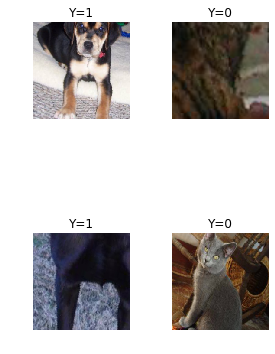

In [8]:
imgs, labels = iter(trainloader).next()
plot_results(imgs[:4, :], labels)

# Defining and Training Model from Scratch

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    
    # layers
    self.fc1 = nn.Linear(150528, 1024)
    self.fc2 = nn.Linear(1024, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 2)
    
    # dropout
    self.dropout = nn.Dropout(p=0.2)
    
  def forward(self, x):
    # flatten images
    x = x.view(x.shape[0], -1)
    
    #forward pass
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    
    # output
    x = F.log_softmax(self.fc4(x), dim=1)
    
    return x  

In [13]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5

train_losses, test_losses = [], []
for e in range(epochs):
  train_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    
    optimizer.step()
    
    train_loss += loss.item()
    
  else:
    
    with torch.no_grad():
      model.eval()
      test_loss = 0
      accuracy = 0
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        _, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print(f'Epoch:{e+1}/{epochs} Train Loss:{train_losses[-1]:.3f} Test Loss:{test_losses[-1]:.3f} Accuracy:{accuracy/len(testloader):.3f}')

Epoch:1/5 Train Loss:1.150 Test Loss:0.694 Accuracy:0.500
Epoch:2/5 Train Loss:0.694 Test Loss:0.695 Accuracy:0.497
Epoch:3/5 Train Loss:0.694 Test Loss:0.693 Accuracy:0.500
Epoch:4/5 Train Loss:0.694 Test Loss:0.693 Accuracy:0.503
Epoch:5/5 Train Loss:0.694 Test Loss:0.693 Accuracy:0.500


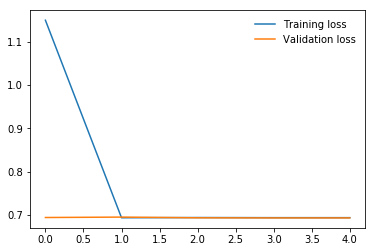

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Isssues

Model is taking too much time. Even with this rather shallow network, a normal machine isn't able to perform well. Just 5 epochs took hours to complete, and  we can see that our model isn't performing well and we need more layers.

### Solution

We need to train a deeper network as well as faster training. For this, we'll use transfer learning and repurpose the pretrained DenseNet 121 and utilize GPU.

# Transfer Learning (with GPU)

### DenseNet 121 


*   Input layer takes 224 x 224 size images, we need to customize our inputs accordingly.
*   We also need to match pretrained Network's normalization. For DenseNet 121, Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225]


### Utilizing GPU with Pytorch


*   For computation, we'll move our model paramters and other tensors to the GPU memory using model.to('cuda')
*   Once done, we can move back our resources using model.to('cpu')






In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

### Loading & Transforming Data

In [0]:
# base dir where our data is
data_dir = 'datasets/cat-dog-data/'

# defining transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30), 
                                       transforms.RandomResizedCrop(224), 
                                       transforms.RandomHorizontalFlip(), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.Resize(255), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ])

In [0]:
# loading data
train_data = datasets.ImageFolder(data_dir+'train', 
                                  transform=train_transforms)
test_data = datasets.ImageFolder(data_dir+'test', 
                                 transform=test_transforms)

# data loader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

### Downloading and setting up the pretrained DenseNet 121 

In [0]:
# downloading the network
model = models.densenet121(pretrained=True)

# see model structure
model

We need to change the classifier since it outputs 1000 features while we just need two. So We'll replace the original classifier with our custom classifier

In [0]:
# We don't need to train the whole network, just the classifier layer
# Freeze params of model so we don't do backprop through them
for param in model.parameters():
  param.requires_grad = False
  
# classifier
model.classifier = nn.Sequential(nn.Linear(1024, 256), 
                           nn.ReLU(), 
                           nn.Dropout(p=0.2), 
                           nn.Linear(256, 2), 
                           nn.LogSoftmax(dim=1))

### Training Network

In [0]:
# hyper params
lr = 0.003
epochs = 15

In [0]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# loss and optimizer; only train classifier layer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

# move model to GPU (if available)
model.to(device)

In [43]:
# train network
train_losses, test_losses = [], []
for epoch in range(epochs):
  train_loss = 0
  
  # turn on dropout
  model.train()
  
  # train
  for inputs, labels in trainloader:
    # move data to GPU (if available)
    inputs, labels = inputs.to(device), labels.to(device)
    
    # set prev gradients to zero
    optimizer.zero_grad()
    
    # forward prop and loss
    loss = criterion(model.forward(inputs), labels)
    
    # backprop
    loss.backward()
    
    # update weights and bias
    optimizer.step()
    
    # add to total running train loss
    train_loss += loss.item()
    
  
  # validate model
  # turn off gradient
  with torch.no_grad():
    accuracy = 0
    test_loss = 0
    
    # turn off dropout
    model.eval() 
    
    # validate
    for inputs, labels in testloader:
      
      # move data to GPU (if available)
      inputs, labels = inputs.to(device), labels.to(device)
      
      # forward prop
      logps = model.forward(inputs)
      
      # loss
      test_loss += criterion(logps, labels).item()
      
      # accracy
      _, top_class = torch.exp(logps).topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      
  # add loss to list
  train_losses.append(train_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader))
  
  # print epoch results
  print(f'Epochs {epoch+1}/{epochs}:  \
  Train Loss:{train_losses[-1]:.3f}  \
  Test Loss:{test_losses[-1]:.3f}  \
  Accuracy:{accuracy/len(testloader):.3f}')

Epochs 1/15:    Train Loss:0.183    Test Loss:0.052    Accuracy:0.981
Epochs 2/15:    Train Loss:0.151    Test Loss:0.034    Accuracy:0.986
Epochs 3/15:    Train Loss:0.142    Test Loss:0.047    Accuracy:0.982
Epochs 4/15:    Train Loss:0.143    Test Loss:0.043    Accuracy:0.984
Epochs 5/15:    Train Loss:0.143    Test Loss:0.038    Accuracy:0.983
Epochs 6/15:    Train Loss:0.141    Test Loss:0.037    Accuracy:0.984
Epochs 7/15:    Train Loss:0.134    Test Loss:0.033    Accuracy:0.986
Epochs 8/15:    Train Loss:0.134    Test Loss:0.035    Accuracy:0.986
Epochs 9/15:    Train Loss:0.135    Test Loss:0.031    Accuracy:0.988
Epochs 10/15:    Train Loss:0.133    Test Loss:0.030    Accuracy:0.988
Epochs 11/15:    Train Loss:0.131    Test Loss:0.031    Accuracy:0.988
Epochs 12/15:    Train Loss:0.132    Test Loss:0.033    Accuracy:0.985
Epochs 13/15:    Train Loss:0.134    Test Loss:0.032    Accuracy:0.987
Epochs 14/15:    Train Loss:0.131    Test Loss:0.033    Accuracy:0.986
Epochs 15/15:  

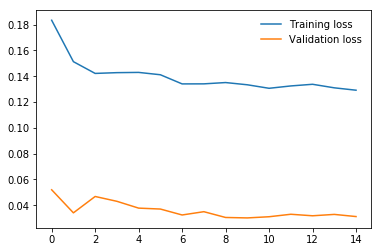

In [44]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Sample Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


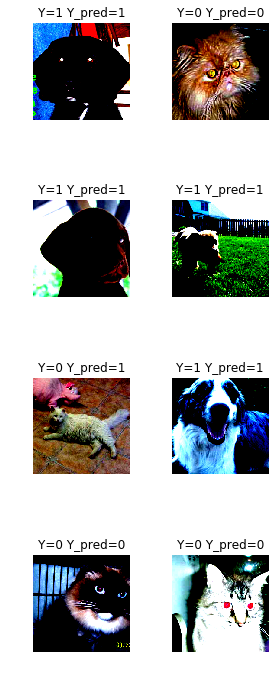

In [81]:
# turn off grad
with torch.no_grad():
  # turn off dropout
  model.eval()
  
  # get a test batch
  imgs, labels = iter(testloader).next()
  
  # move data to GPU
  imgs, labels = imgs.to(device), labels.to(device)
  
  # get prob
  _, pred_labels = torch.exp(model.forward(imgs)).topk(1, dim=1)
  
  # move data back to CPU
  imgs, labels = imgs.to('cpu'), labels.to('cpu')
  pred_labels = pred_labels.to('cpu')

  plot_results(imgs[:8, :], 
               labels[:8], 
               predictions=pred_labels[:8], 
               title='Dataset Images')

### Saving Model

In [0]:
# Downloading models in Colab (only usable for current session)
!mkdir models
torch.save(model.state_dict(), 'models/densenet121-binary-checkpoint.pth')
!ls models

In [0]:
# Saving models to Personal Google Drive
# You will be asked for authorization
from google.colab import drive
drive.mount('/content/gdrive')
torch.save(model.state_dict(), '/content/gdrive/My Drive/densenet121-binary-checkpoint.pth')

In [0]:
# loading model from Google drive
state_dict = torch.load('/content/gdrive/My Drive/densenet121-binary-checkpoint.pth')
